In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,BatchNormalization# type: ignore
from keras.optimizers import Adam
import cv2 as cv
from keras.utils import to_categorical

from PIL import Image

In [6]:
# Load the data
split_df = pd.read_csv('split_df.csv', encoding='utf-8-sig')


In [7]:
split_df

,Table 1,Spectacles,Age,Gender,Name,id,Eye,VA,CDR,Diagnosis,IOP,Image
0,زرق أيمن تم معالجته جراحيا,0.0,64,0,شاهين ميرو,1.0,0,0.6,0.5,0,14.0,Data/SHAHEN_MERO Optic nerve.png_ left.png
1,زرق أيمن تم معالجته جراحيا,0.0,64,0,شاهين ميرو,1.0,1,0.7,0.9,1,23.0,Data/SHAHEN_MERO Optic nerve.png_ left.png
2,زرق متقدم,1.0,62,0,أيمن سمارة,2.0,0,NaN,NaN,1,25.0,Data/SHAHEN_MERO Optic nerve.png_ right.png
3,زرق متقدم,1.0,62,0,أيمن سمارة,2.0,1,9.0,0.8,1,40.0,Data/SHAHEN_MERO Optic nerve.png_ right.png
4,لا يوجد زرق,0.0,48,1,رندة ناصر,3.0,0,1.0,0.5,0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85,زرق أيسر تم معالجته جراحيا,1.0,55,1,زريفة المحمد,43.0,1,NaN,NaN,0,NaN,Data/BASEL_BASH Optic nerve.png_ left.png
86,مريض زرقي ثانوي بعد استخراج ساد لا يوجد اصابة ...,0.0,71,0,هيثم قزاز,44.0,0,0.3,0.5,1,15.0,Data/BASEL_BASH Optic nerve.png_ right.png
87,مريض زرقي ثانوي بعد استخراج ساد لا يوجد اصابة ...,0.0,71,0,هيثم قزاز,44.0,1,0.6,0.7,1,16.0,Data/BASEL_BASH Optic nerve.png_ right.png
88,لا يوجد زرق,1.0,65,0,حمود غشام,45.0,0,0.5,0.3,0,15.0,Data/NEZAR_HELOU Optic nerve.png_ left.png


In [8]:
split_df = split_df.drop(['Table 1', 'Gender', 'id', 'Age', 'Spectacles'], axis=1)

In [9]:
split_df['Image'].isnull().sum()

4

In [10]:
# split_df['Image']
split_df[split_df['Image'].isnull()]

,Name,Eye,VA,CDR,Diagnosis,IOP,Image
4,رندة ناصر,0,1.0,0.5,0,15.0,NaN
5,رندة ناصر,1,1.0,0.4,0,14.0,NaN
18,خديجة كبة,0,0.5,0.3,1,36.0,NaN
19,خديجة كبة,1,0.7,0.3,0,17.0,NaN


In [11]:
split_df = split_df.drop(['Name','Eye','VA','CDR','IOP'], axis=1)

In [12]:
# split_df.dropna(inplace=True)

In [13]:
split_df

,Diagnosis,Image
0,0,Data/SHAHEN_MERO Optic nerve.png_ left.png
1,1,Data/SHAHEN_MERO Optic nerve.png_ left.png
2,1,Data/SHAHEN_MERO Optic nerve.png_ right.png
3,1,Data/SHAHEN_MERO Optic nerve.png_ right.png
4,0,NaN
...,...,...
85,0,Data/BASEL_BASH Optic nerve.png_ left.png
86,1,Data/BASEL_BASH Optic nerve.png_ right.png
87,1,Data/BASEL_BASH Optic nerve.png_ right.png
88,0,Data/NEZAR_HELOU Optic nerve.png_ left.png


In [14]:
# orb = cv.ORB_create()

# def extract_orb_features(image_path):
#     image = cv.imread(image_path)
#     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#     keypoints, descriptors = orb.detectAndCompute(gray, None)
#     return descriptors.flatten() if descriptors is not None else np.zeros(500)

In [15]:
# split_df['ORB_features'] = split_df['Image'].apply(extract_orb_features)

In [16]:
split_df.count() 

Diagnosis    90
Image        86
dtype: int64

In [17]:
split_df.dropna(inplace=True)

In [18]:
# Drop columns not used for prediction
y_data = split_df['Diagnosis']
X_data = split_df.drop('Diagnosis', axis=1)

In [19]:
print(y_data.count())
print(X_data.count())

86
Image    86
dtype: int64


In [20]:
# Load and preprocess images for each patient
image_paths =  split_df['Image'].tolist()


In [21]:
image_paths

['Data/SHAHEN_MERO Optic nerve.png_ left.png',
 'Data/SHAHEN_MERO Optic nerve.png_ left.png',
 'Data/SHAHEN_MERO Optic nerve.png_ right.png',
 'Data/SHAHEN_MERO Optic nerve.png_ right.png',
 'Data/AYMAN_SAMARA_20240121_124719_Disc_3D_R_SINGLE_6mm_512x112.png',
 'Data/AYMAN_SAMARA_20240121_124719_Disc_3D_R_SINGLE_6mm_512x112.png',
 'Data/RAMA_NASR_ALL Optic nerve.png_ left.png',
 'Data/RAMA_NASR_ALL Optic nerve.png_ left.png',
 'Data/RANDA_NASER_2 Optic nerve.png_ right.png',
 'Data/RANDA_NASER_2 Optic nerve.png_ right.png',
 'Data/MOUSTAFA_MALA_ALI Optic nerve.png_ left.png',
 'Data/MOUSTAFA_MALA_ALI Optic nerve.png_ left.png',
 'Data/MOUSTAFA_MALA_ALI Optic nerve.png_ right.png',
 'Data/MOUSTAFA_MALA_ALI Optic nerve.png_ right.png',
 'Data/6361_NAHLA_ABO_QORA_left.png',
 'Data/6361_NAHLA_ABO_QORA_left.png',
 'Data/LATEFA_IBRAHEM Optic nerve.png_ left.png',
 'Data/LATEFA_IBRAHEM Optic nerve.png_ left.png',
 'Data/LATEFA_IBRAHEM Optic nerve.png_ right.png',
 'Data/LATEFA_IBRAHEM Optic n

In [22]:
images = [np.array(Image.open(path).convert('RGB').resize((200, 200))) for path in image_paths]  # Load and resize images
X_images = np.array(images) / 255.0  # Normalize pixel values to range [0, 1]

In [23]:
len(X_images)

86

In [24]:
# X_images = []
# # cv.imshow('',X_images)
# # cv.waitKey(0)
# # cv.destroyAllWindows()
# for i in range(len(image_paths)):
#     img = cv.imread(image_paths[i])
#     flattened_image = img.flatten()
#     X_images.append(flattened_image)

In [25]:
# X_train = np.concatenate((X_data, X_images), axis=1)
# X_data['images'] = X_images['Image']
# for i in range(len(X_images)):
#     X_data.at[i, 'images'] = X_images.at[i, 'Image']


In [37]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y_data, test_size=0.2, random_state=44, shuffle=True)


In [27]:
len(X_train)

68

In [194]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Dropout(rate=0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [195]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [196]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       7

In [197]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1)


Epoch 1/100
8/8 [==============================] - 6s 399ms/step - loss: 0.7672 - accuracy: 0.4754 - val_loss: 0.6955 - val_accuracy: 0.4286
Epoch 2/100
8/8 [==============================] - 3s 328ms/step - loss: 0.6813 - accuracy: 0.6066 - val_loss: 0.7064 - val_accuracy: 0.4286
Epoch 3/100
8/8 [==============================] - 3s 325ms/step - loss: 0.7275 - accuracy: 0.6066 - val_loss: 0.7089 - val_accuracy: 0.4286
Epoch 4/100
8/8 [==============================] - 3s 321ms/step - loss: 0.6714 - accuracy: 0.6066 - val_loss: 0.6965 - val_accuracy: 0.4286
Epoch 5/100
8/8 [==============================] - 3s 330ms/step - loss: 0.6833 - accuracy: 0.6066 - val_loss: 0.6966 - val_accuracy: 0.4286
Epoch 6/100
8/8 [==============================] - 3s 326ms/step - loss: 0.6780 - accuracy: 0.6066 - val_loss: 0.7025 - val_accuracy: 0.4286
Epoch 7/100
8/8 [==============================] - 3s 327ms/step - loss: 0.7012 - accuracy: 0.6066 - val_loss: 0.7095 - val_accuracy: 0.4286
Epoch 8/100
8

In [198]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

1/1 [==============================] - 0s 217ms/step - loss: 2.0368 - accuracy: 0.6667
Test Accuracy: 0.6666666865348816


In [199]:
# Evaluate the model
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print('CNN Train Score:', train_score)
print('CNN Test Score:', test_score)


1/1 [==============================] - 0s 331ms/step - loss: 2.0368 - accuracy: 0.6667
CNN Train Score: [0.39827030897140503, 0.8235294222831726]
CNN Test Score: [2.036759614944458, 0.6666666865348816]


In [200]:
# Make predictions on the test set
predictions = model.predict(X_test)


1/1 [==============================] - 0s 353ms/step


In [201]:
# # Generate classification report and confusion matrix
# print('Classification Report:')
# print(classification_report(y_test, predictions))

# print('Confusion Matrix:')
# print(confusion_matrix(y_test, predictions))


In [28]:
from keras.backend import clear_session
clear_session()

In [38]:
from keras.utils import to_categorical


# X_test = X_test.reshape(-1,200,200,1) # -1 => means all the number in the set(the biggest number)
# X_train = X_train.reshape(-1,200,200,1)
X_train = X_train/(255 - 0)
X_test  = X_test /(255 - 0)

In [39]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [40]:
y_train.shape

(68, 2)

In [41]:
X_train.shape

(68, 200, 200, 3)

In [42]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)))
model_2.add(MaxPooling2D())
model_2.add(BatchNormalization())
model_2.add(Dropout(rate=0.6))
model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(rate=0.6))
model_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(rate=0.6))
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(2, activation='softmax'))

#Compilation of the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 99, 99, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 99, 99, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 97, 97, 64)       

In [43]:

hist_2 = model_2.fit(X_train, y_train, 
                batch_size=32,
                epochs=50,
                verbose=True,
                validation_split= 0.1)

Epoch 1/50


2/2 [==============================] - 14s 6s/step - loss: 9.4807 - acc: 0.4754 - val_loss: 0.7444 - val_acc: 0.4286
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 8.5809 - acc: 0.7541 - val_loss: 1.3569 - val_acc: 0.4286
Epoch 3/50
2/2 [==============================] - 6s 3s/step - loss: 4.4875 - acc: 0.7377 - val_loss: 1.7864 - val_acc: 0.4286
Epoch 4/50
2/2 [==============================] - 7s 3s/step - loss: 5.4790 - acc: 0.6066 - val_loss: 0.9527 - val_acc: 0.4286
Epoch 5/50
2/2 [==============================] - 6s 3s/step - loss: 2.8797 - acc: 0.7213 - val_loss: 0.7024 - val_acc: 0.4286
Epoch 6/50
2/2 [==============================] - 6s 3s/step - loss: 4.4430 - acc: 0.6885 - val_loss: 0.7234 - val_acc: 0.4286
Epoch 7/50
2/2 [==============================] - 6s 3s/step - loss: 3.4215 - acc: 0.7705 - val_loss: 0.7103 - val_acc: 0.4286
Epoch 8/50
2/2 [==============================] - 6s 3s/step - loss: 4.9481 - acc: 0.7705 - val_loss: 0.7236

In [47]:
train_score = model_2.evaluate(X_train, y_train)
test_score = model_2.evaluate(X_test, y_test)
print('CNN Train Score:', train_score)
print('CNN Test Score:', test_score)


1/1 [==============================] - 0s 219ms/step - loss: 3.6617 - acc: 0.4444
CNN Train Score: [2.70820689201355, 0.5882353186607361]
CNN Test Score: [3.6616804599761963, 0.4444444477558136]


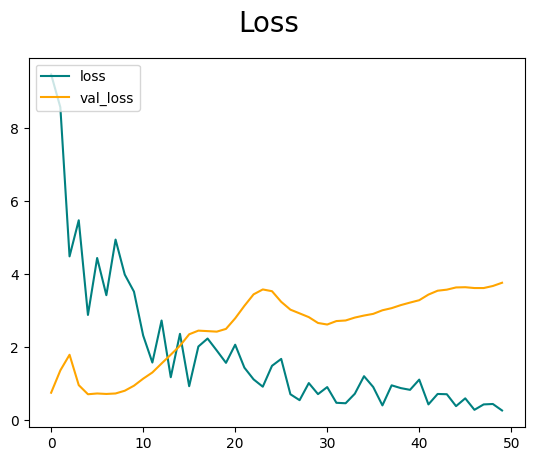

In [48]:
fig = plt.figure()
plt.plot(hist_2.history['loss'], color='teal', label='loss')
plt.plot(hist_2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

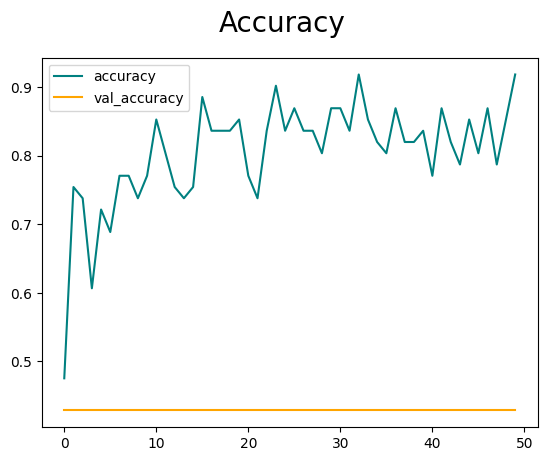

In [49]:
fig = plt.figure()
plt.plot(hist_2.history['acc'], color='teal', label='accuracy')
plt.plot(hist_2.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()